In [1]:
# 231108
# plot the eda for the datasets

In [2]:
import os
import copy
import time
import pickle
import numpy as np
from tqdm import tqdm

import torch
# from tensorboardX import SummaryWriter

from options import args_parser
from update import LocalUpdate, test_inference
from models import MLP, CNNMnist, CNNFashion_Mnist, CNNCifar, WeightAverage
from utils import get_dataset, average_weights, exp_details, model_register_parametrization, model_remove_parametrizations
import torch.nn.utils.parametrize as parametrize

import random
import torch
from torch.utils.data import random_split, DataLoader
import numpy as np


In [3]:

import copy
import torch
from torchvision import datasets, transforms
from sampling import mnist_iid, mnist_noniid, mnist_noniid_unequal, mnist_noniid_mix
from sampling import cifar_iid, cifar_noniid
from torch import nn
import torch.nn.functional as F
from torch.optim import Optimizer
import torch.nn.utils.parametrize as parametrize
from models import WeightAverageParametrization

In [4]:
import numpy as np
from torchvision import datasets, transforms

In [5]:
inputCommand = '--model=cnn --dataset=mnist --gpu=0 --iid=0 --epochs=20 --local_ep=1 --frac=1 --num_users=5 --scaffold=1 --weighted=0'

In [86]:
class myArgs:
    dataset = 'mnist'
    iid = 0
    unequal = 1
    num_classes = 10
    mix = 0
    num_users = 5

In [87]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

/home/kahou/anaconda3/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [88]:
resArr4target = []
resArr4client = []

for tmpKey in user_groups.keys():
    

    tmpTarget = train_dataset.targets[user_groups[tmpKey].astype(int)].numpy()
    
    tmpClient = np.array([tmpKey for i in range(len(tmpTarget))])
    
    resArr4target.append(tmpTarget)
    resArr4client.append(tmpClient)
    
import pandas as pd
resLabel4clientDf = pd.DataFrame.from_dict({'client':np.concatenate(resArr4client),
                       'target':np.concatenate(resArr4target)})

resLabel4clientDf.to_csv('mnist_niid_unique.csv', index=False, header=True)

In [61]:
train_dataset.targets.shape

torch.Size([60000])

In [62]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [63]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])
trainSetReshape.shape

torch.Size([60000, 784])

In [64]:
# user_groups.keys()
for tmpKey in user_groups.keys():
    print(user_groups[tmpKey].shape)

(24000,)
(4800,)
(20000,)
(9600,)
(1600,)


In [12]:
nSampleNumber = 10000

In [13]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
X = trainSetReshape[1:nSampleNumber]
# X = RobustScaler().fit_transform(X.T).T
# X = RobustScaler().fit_transform(X)
X = StandardScaler().fit_transform(X.T).T
# X = StandardScaler().fit_transform(X)

In [14]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

# from sklearn.manifold import MDS
# X_embedded = MDS(n_components=2, normalized_stress='auto').fit_transform(X)

# from sklearn.manifold import SpectralEmbedding
# X_embedded = SpectralEmbedding(n_components=2, random_state=29, affinity='rbf').fit_transform(X)


In [15]:
def plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr):
    '''
    input: label arr, x_embedded
    output: tsne
    '''
    import matplotlib.pyplot as plt
    import numpy as np
    
    # colorArr = ["#9e0142", "#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2"]
    
    # plt.figure()
    plt.figure(figsize=(10,10))
    for tmpIndex, tmpLabel in enumerate(np.unique(labelArr)):
        plt.scatter(X_embedded[labelArr == tmpLabel, 0], 
                    X_embedded[labelArr == tmpLabel, 1],
                    c = colorArr[tmpIndex], 
                    alpha = 0.6,
                    label = tmpLabel)
    plt.xlabel('tSNE1')
    plt.ylabel('tSNE2')
    plt.legend()
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

In [16]:
user_groups[0][1]

44992.0

In [17]:
colorArr = ["#9e0142", "#d53e4f", "#f46d43", "#fdae61", "#fee08b", "#e6f598", "#abdda4", "#66c2a5", "#3288bd", "#5e4fa2", "#ffffbf"] # "#ffffbf",

In [18]:
labelArr = train_dataset.targets[1:nSampleNumber]

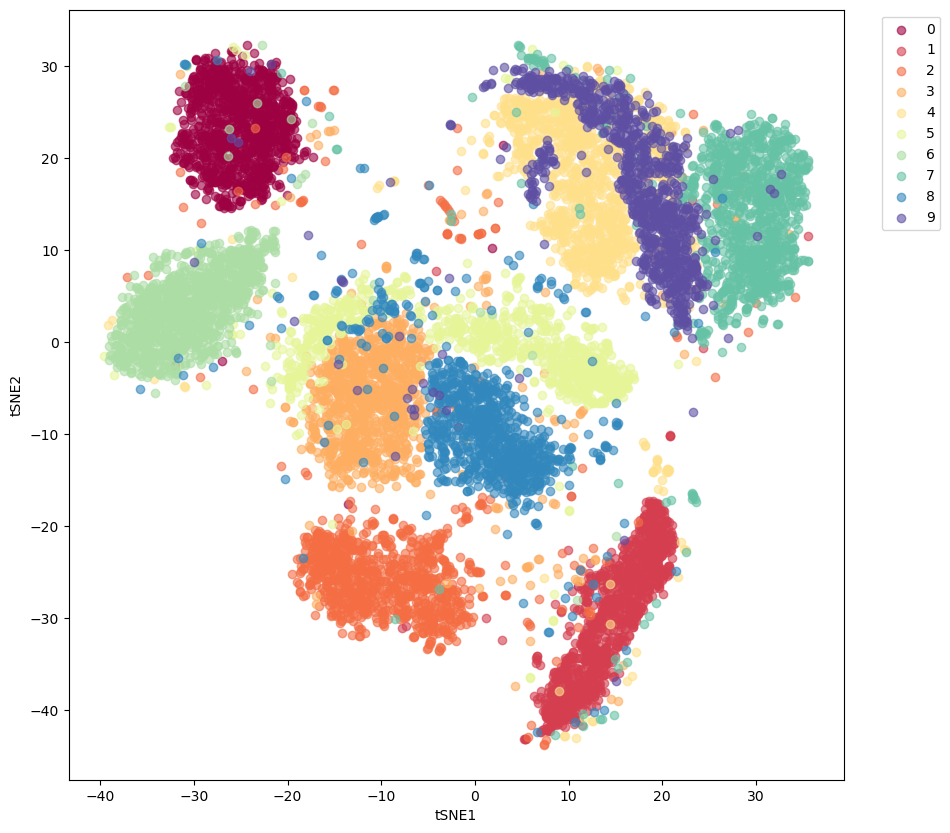

In [19]:
import matplotlib.pyplot as plt 

plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [20]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])

In [21]:
# user_groups
# user_groups.keys()
for tmpKey in user_groups.keys():
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

In [22]:
clientLabelNpArr

array([1., 3., 3., ..., 3., 3., 2.])

In [23]:
colorArr2 = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']

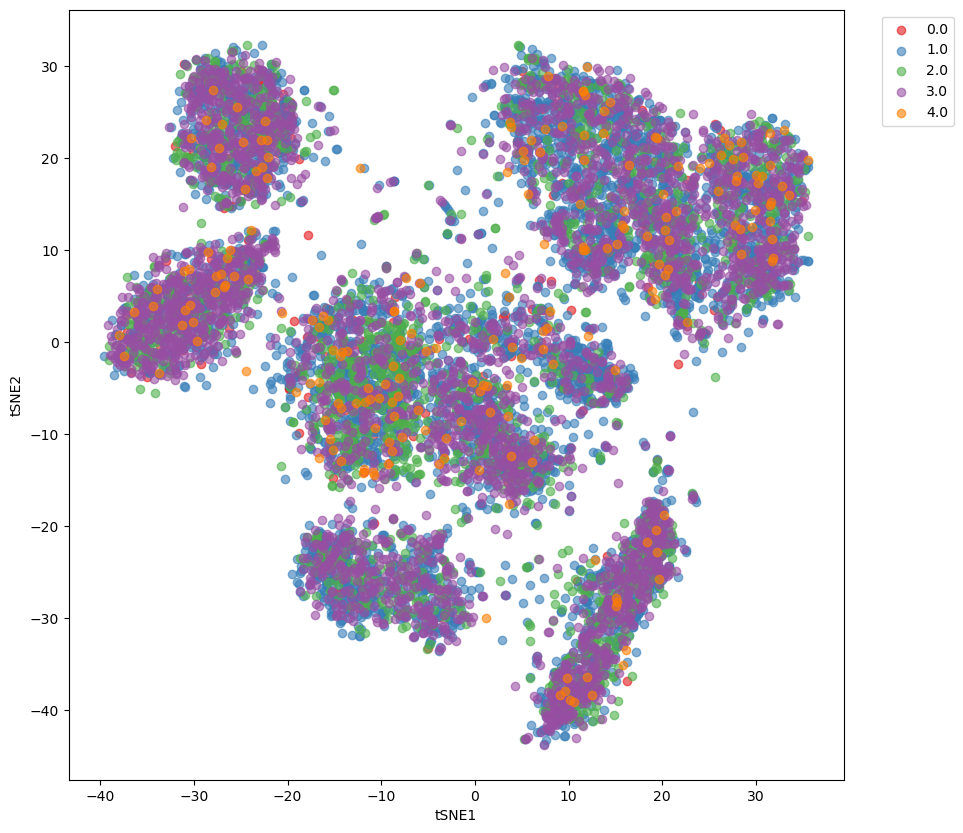

In [24]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr2)

In [89]:
class myArgs:
    dataset = 'mnist'
    iid = 0
    unequal = 0
    num_classes = 10
    mix = 0
    num_users = 5

In [90]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

In [91]:
resArr4target = []
resArr4client = []

for tmpKey in user_groups.keys():
    

    tmpTarget = train_dataset.targets[user_groups[tmpKey].astype(int)].numpy()
    
    tmpClient = np.array([tmpKey for i in range(len(tmpTarget))])
    
    resArr4target.append(tmpTarget)
    resArr4client.append(tmpClient)
    
import pandas as pd
resLabel4clientDf = pd.DataFrame.from_dict({'client':np.concatenate(resArr4client),
                       'target':np.concatenate(resArr4target)})

resLabel4clientDf.to_csv('mnist_niid_equal.csv', index=False, header=True)

In [27]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [28]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [29]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

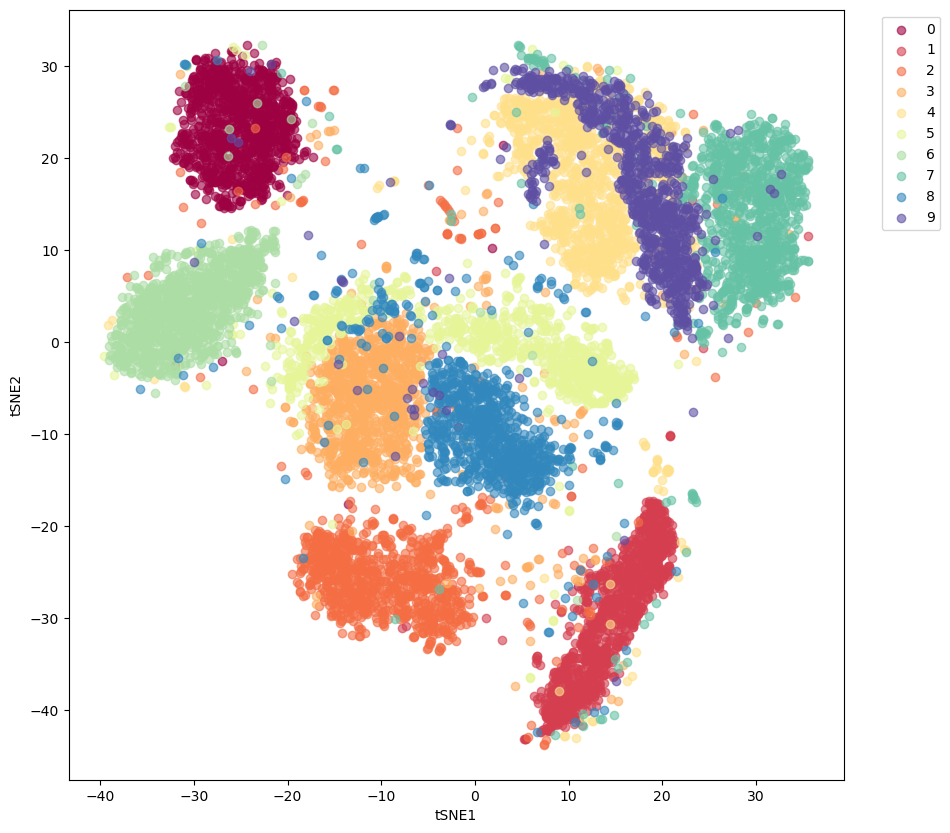

In [30]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [31]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    print(len(user_groups[tmpKey].astype(int)))
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

12000
12000
12000
12000
12000


In [32]:
user_groups[0].astype(int)

array([22665,  5846, 55226, ...,  8225, 21041, 53331])

In [33]:
train_dataset.targets[user_groups[0].astype(int)]

tensor([6, 6, 6,  ..., 6, 6, 6])

In [34]:
np.unique(train_dataset.targets[user_groups[0].astype(int)], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([ 900,  600,  900, 1500, 1200,  900, 2335, 1865,  900,  900]))

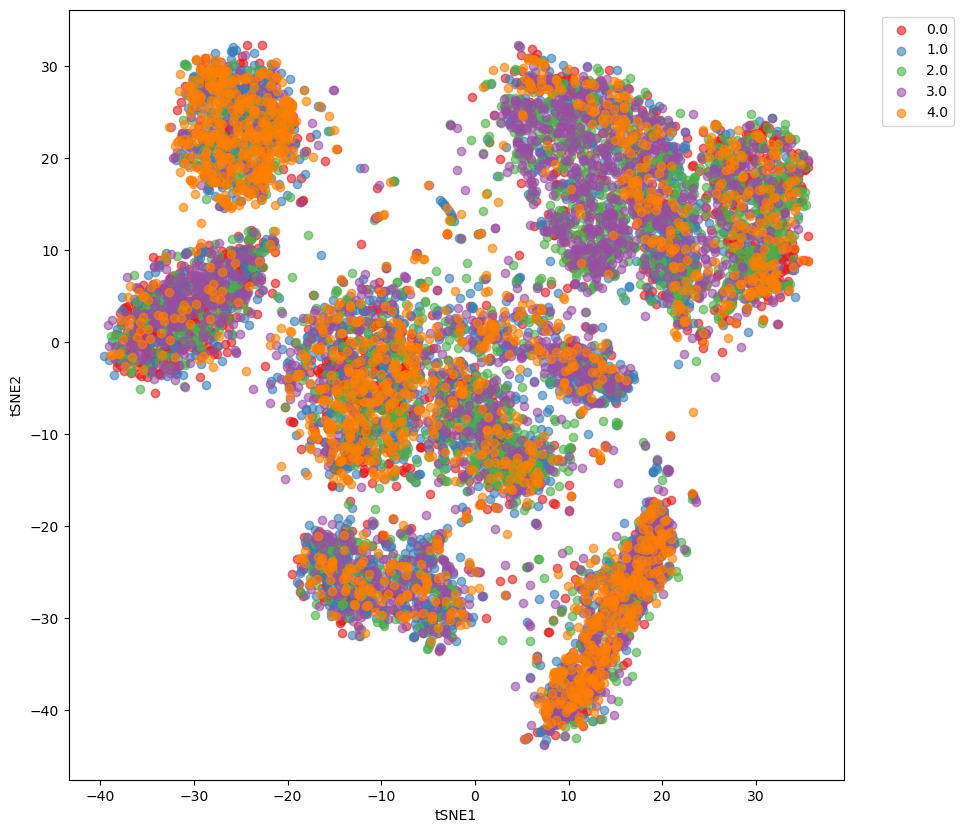

In [35]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr2)

In [92]:
class myArgs:
    dataset = 'mnist'
    iid = 1
    unequal = 0
    num_classes = 10
    mix = 0
    num_users = 5

In [93]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

In [95]:
resArr4target = []
resArr4client = []

for tmpKey in user_groups.keys():
    

    tmpTarget = train_dataset.targets[np.array(list(user_groups[tmpKey]))].numpy()
    
    tmpClient = np.array([tmpKey for i in range(len(tmpTarget))])
    
    resArr4target.append(tmpTarget)
    resArr4client.append(tmpClient)
    
import pandas as pd
resLabel4clientDf = pd.DataFrame.from_dict({'client':np.concatenate(resArr4client),
                       'target':np.concatenate(resArr4target)})

resLabel4clientDf.to_csv('mnist_iid.csv', index=False, header=True)

In [38]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [39]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [40]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

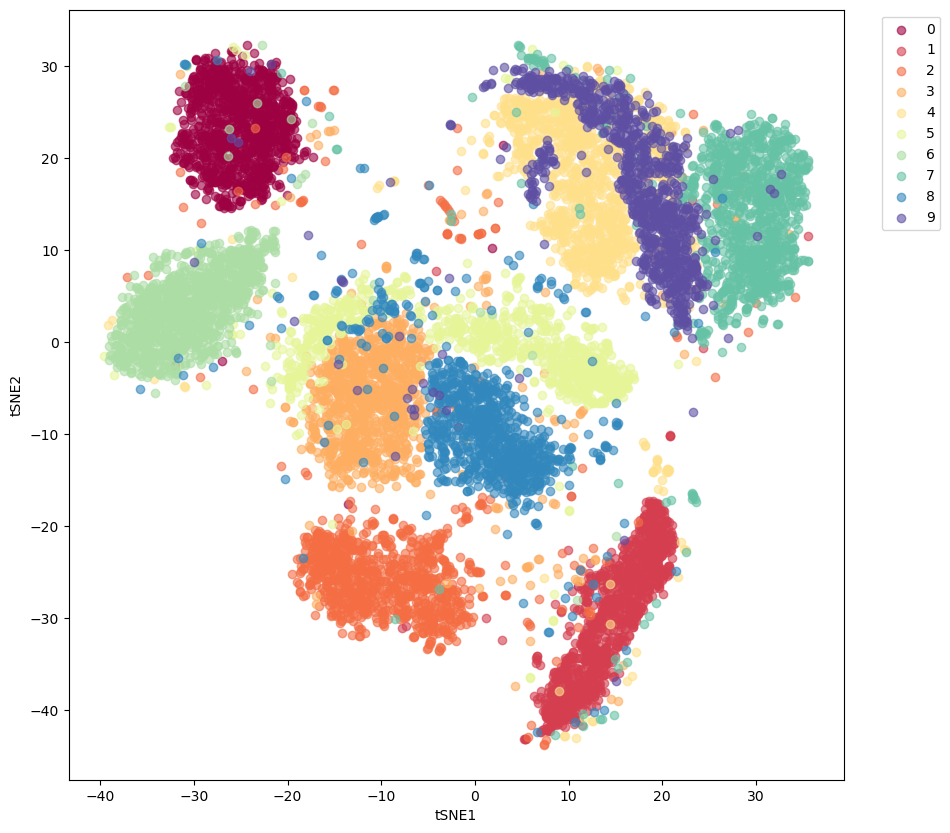

In [41]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [42]:
np.array(list(user_groups[0]))

array([32773, 32774,     7, ..., 32764, 32766, 32767])

In [43]:
train_dataset.targets[list(user_groups[0])]

tensor([1, 8, 3,  ..., 3, 8, 9])

In [44]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    clientLabelNpArr[np.array(list(user_groups[tmpKey]))] = tmpKey

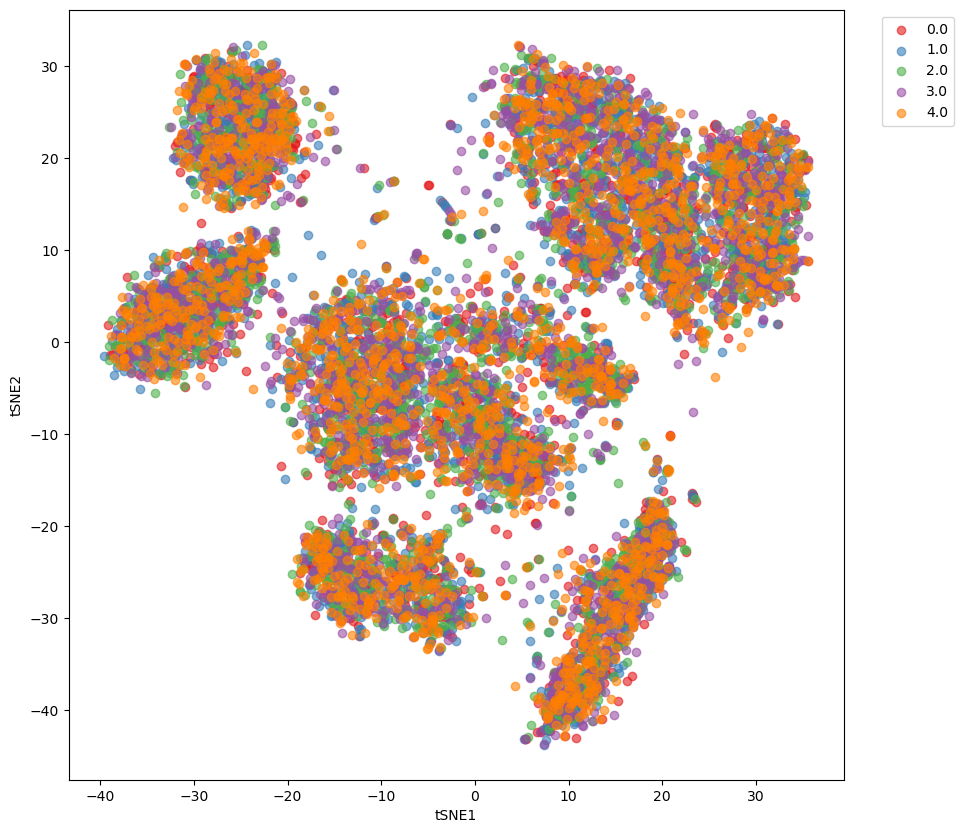

In [45]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr2)

In [96]:
class myArgs:
    dataset = 'mnist'
    iid = 0
    unequal = 0
    num_classes = 10
    mix = 1
    num_users = 5

In [97]:
train_dataset, test_dataset, user_groups = get_dataset(myArgs)

len(dict_users[0]) 2:  12000
len(dict_users[1]) 2:  12000
len(dict_users[2]) 2:  12000
len(dict_users[3]) 2:  12000
len(dict_users[4]) 2:  12000


In [98]:
resArr4target = []
resArr4client = []

for tmpKey in user_groups.keys():
    

    tmpTarget = train_dataset.targets[user_groups[tmpKey].astype(int)].numpy()
    
    tmpClient = np.array([tmpKey for i in range(len(tmpTarget))])
    
    resArr4target.append(tmpTarget)
    resArr4client.append(tmpClient)
    
import pandas as pd
resLabel4clientDf = pd.DataFrame.from_dict({'client':np.concatenate(resArr4client),
                       'target':np.concatenate(resArr4target)})

resLabel4clientDf.to_csv('mnist_niid_mix.csv', index=False, header=True)

In [48]:
trainSetReshape = train_dataset.data.reshape([60000, 28*28])

In [49]:
X = trainSetReshape[1:nSampleNumber]
X = StandardScaler().fit_transform(X.T).T

In [50]:
X_embedded = TSNE(n_components=2, 
                  learning_rate='auto', 
                  random_state=29,
                  init='random', 
                  perplexity=200
                 ).fit_transform(X)

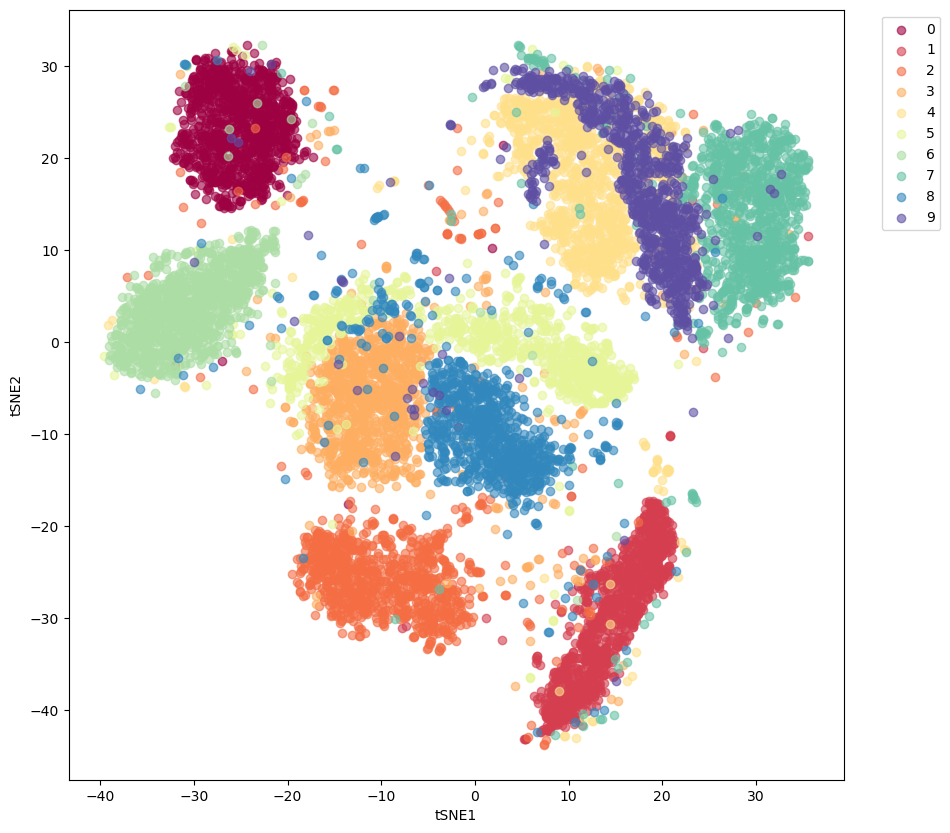

In [51]:
labelArr = train_dataset.targets[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr)

In [52]:
clientLabelNpArr = np.zeros(trainSetReshape.shape[0])
for tmpKey in user_groups.keys():
    clientLabelNpArr[user_groups[tmpKey].astype(int)] = tmpKey

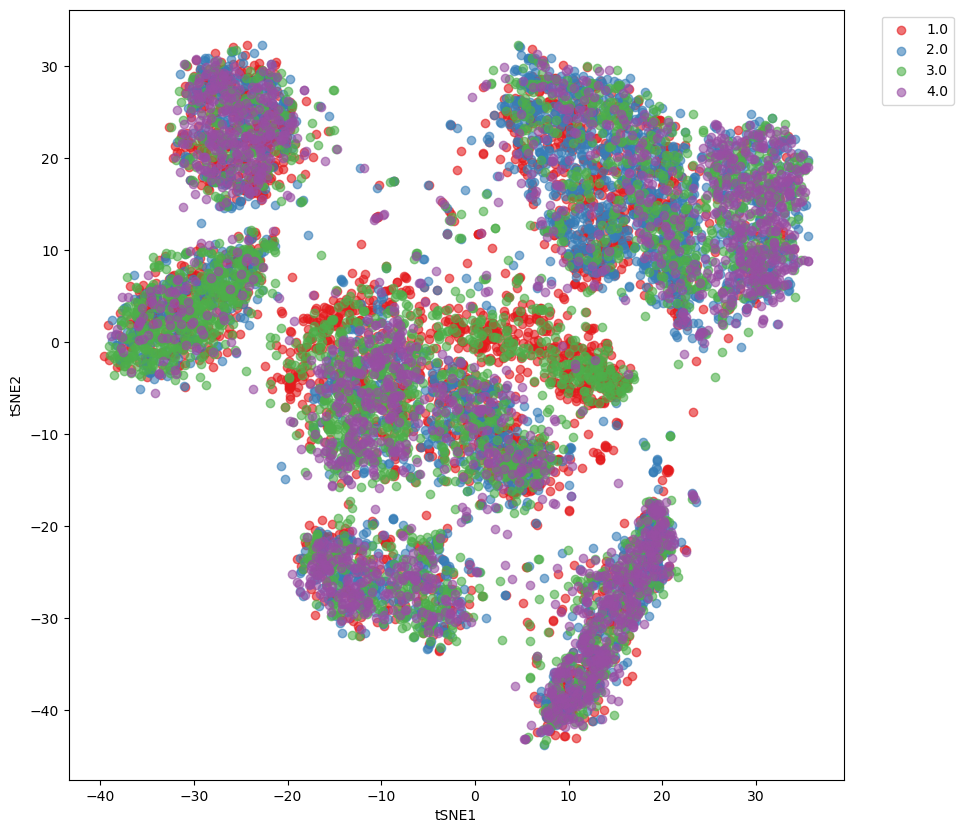

In [53]:
labelArr = clientLabelNpArr[1:nSampleNumber]
plotLabelDistribution4sc_tsne(labelArr, X_embedded, colorArr2)

In [54]:
num_users = 5

num_shards, num_imgs = 200, 300
idx_shard = [i for i in range(num_shards)]
dict_users = {i: np.array([]) for i in range(num_users)}
idxs = np.arange(num_shards*num_imgs)

labels = train_dataset.targets

# sort labels
idxs_labels = np.vstack((idxs, labels))
idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
idxs = idxs_labels[1, :]


In [55]:
idxs_labels

array([[30207,  5662, 55366, ..., 23285, 15728, 11924],
       [    0,     0,     0, ...,     9,     9,     9]])

In [56]:
idxs

array([0, 0, 0, ..., 9, 9, 9])

In [57]:

# divide and assign shards/client
for i in range(num_users):
    rand_set = set(np.random.choice(idx_shard, int(200 / num_users), replace=False))
    idx_shard = list(set(idx_shard) - rand_set)
    # print(idx_shard)
    count = 0
    for rand in rand_set:
        dict_users[i] = np.concatenate(
            (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
        
        count = count + 1
        print([count, np.unique(np.array(idxs[rand*num_imgs:(rand+1)*num_imgs]))])
    break

[1, array([0])]
[2, array([0])]
[3, array([6])]
[4, array([0])]
[5, array([6])]
[6, array([0])]
[7, array([0])]
[8, array([7])]
[9, array([7])]
[10, array([0])]
[11, array([7])]
[12, array([1])]
[13, array([1])]
[14, array([1])]
[15, array([1])]
[16, array([8])]
[17, array([8])]
[18, array([8])]
[19, array([8])]
[20, array([2])]
[21, array([2])]
[22, array([9])]
[23, array([2])]
[24, array([9])]
[25, array([9])]
[26, array([9])]
[27, array([3])]
[28, array([3])]
[29, array([4])]
[30, array([4])]
[31, array([4])]
[32, array([4])]
[33, array([4])]
[34, array([4])]
[35, array([5])]
[36, array([5])]
[37, array([5])]
[38, array([5])]
[39, array([5])]
[40, array([5])]


In [58]:
dict_users

{0: array([0., 0., 0., ..., 5., 5., 5.]),
 1: array([], dtype=float64),
 2: array([], dtype=float64),
 3: array([], dtype=float64),
 4: array([], dtype=float64)}